# Comparing Elevation Values

Once you have an area of interest with multiple overlapping DEMs and/or laser altimetry measurements, you can quickly compare elevation values.

In [1]:
import coincident
import geopandas as gpd
import rioxarray as rxr
import rasterio

%matplotlib inline

Let's read in some local DSM data

In [ ]:
# TODO: fix this notebook so the DSMs/DEMs we're comparing are processed via 'coincident' as well
# I used the 1m 3DEP LiDAR and Maxar Stereo DSMs resampled to 1km resolution for efficiency sake
# which caused gridding artifacts

# gdaladdo -q -ro -r gauss --config COMPRESS_OVERVIEW LZW --config BIGTIFF_OVERVIEW YES dem_8m.tif 2 4 8 16
# gdal_translate -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -outsize 125% 125% dem_8m.tif dem_1km.tif
# where the 8m dem above was resampled the same way

In [2]:
# 1km 3dep LiDAR dsm
dsm_lidar = rxr.open_rasterio(
    "/mnt/c/Users/JackE/uw/STV/agu_24/data/co_als_1km.tif", masked=True
)
# 1km stereo dsm
dsm_stereo = rxr.open_rasterio(
    "/mnt/c/Users/JackE/uw/STV/agu_24/data/co_stereo_dsm_1km.tif", masked=True
)
# COP30 DEM (1km)
da_cop30 = rxr.open_rasterio(
    "/mnt/c/Users/JackE/uw/STV/agu_24/data/cop30_1km.tif", masked=True
)

# align our datasets
crs_utm = "EPSG:32613"
dsm_lidar.rio.write_crs(crs_utm, inplace=True)
da_cop30.rio.write_crs(crs_utm, inplace=True)
dsm_stereo.rio.write_crs(crs_utm, inplace=True)
da_cop30_r = da_cop30.rio.reproject_match(
    dsm_lidar, resampling=rasterio.enums.Resampling.bilinear
)
dsm_stereo_r = dsm_stereo.rio.reproject_match(
    dsm_lidar, resampling=rasterio.enums.Resampling.bilinear
)

In [3]:
# now, let's pull in coincident ICESat-2 and GEDI data

# aoi of our aligned DEMs
aoi = gpd.read_file(
    "/mnt/c/Users/JackE/uw/finesst_24/data/co_site/CO_WestCentral_2019_overlap_bbox.geojson"
)
# Get GEDI
gf_gedi = coincident.search.search(
    dataset="gedi",
    intersects=aoi,
    datetime=["2019-08", "2019-10"],
)
data_gedi = coincident.io.sliderule.subset_gedi02a(
    gf_gedi, aoi, include_worldcover=True
)
# Get ICESAT-2
gf_is2 = coincident.search.search(
    dataset="icesat-2",
    intersects=aoi,
    datetime=["2019-08", "2019-10"],
)
data_is2 = coincident.io.sliderule.subset_atl06(gf_is2, aoi, include_worldcover=True)

data_is2_p = data_is2.to_crs(dsm_lidar.rio.crs)
data_gedi_p = data_gedi.to_crs(dsm_lidar.rio.crs)
# our GeoDataFrames of interest containing ICESat-2 and GEDI points and their elevations
# subsampled for efficiency and visualization purposes
subset_is2 = data_is2_p.sample(1000)
subset_gedi = data_gedi_p.sample(1000)

### Main Elevation Comparison Panel

'coincident' supports a main `compare_dems` function that allows you to compare multiple DEMs and altimetry points in a single panel. This function dynamically adjusts based on the number of datasets provided.

```{note}
`compare_dems` assumes that all DEMs are in the same coordinate reference system (CRS) and aligned. It also assumes that each DEM has an 'elevation' variable and 'hillshade' variable, where the 'hillshade' variable can be calculated with `coincident.plot.create_hillshade` as seen below. A minimum of two DEMs must be provided and a maximum of 5 total datasets (datasets being DEMs and GeoDataFrames of altimetry points) can be provided.
```

In [4]:
# let's cast our DEMs to datasets for plotting
dsm_lidar = dsm_lidar.to_dataset(name="elevation")
dsm_stereo_r = dsm_stereo_r.to_dataset(name="elevation")
da_cop30_r = da_cop30_r.to_dataset(name="elevation")

# and let's create hillshade variables
dsm_lidar["hillshade"] = (
    ("y", "x"),
    coincident.plot.create_hillshade(dsm_lidar.elevation.squeeze()),
)
dsm_stereo_r["hillshade"] = (
    ("y", "x"),
    coincident.plot.create_hillshade(dsm_stereo_r.elevation.squeeze()),
)
da_cop30_r["hillshade"] = (
    ("y", "x"),
    coincident.plot.create_hillshade(da_cop30_r.elevation.squeeze()),
)

/home/jehayes/coincident/src/coincident/plot/matplotlib.py:241: RuntimeWarning: invalid value encountered in cast
  return data.astype(np.uint8)


/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape geometry at index 0 will not be rasterized.
  warnings.warn(


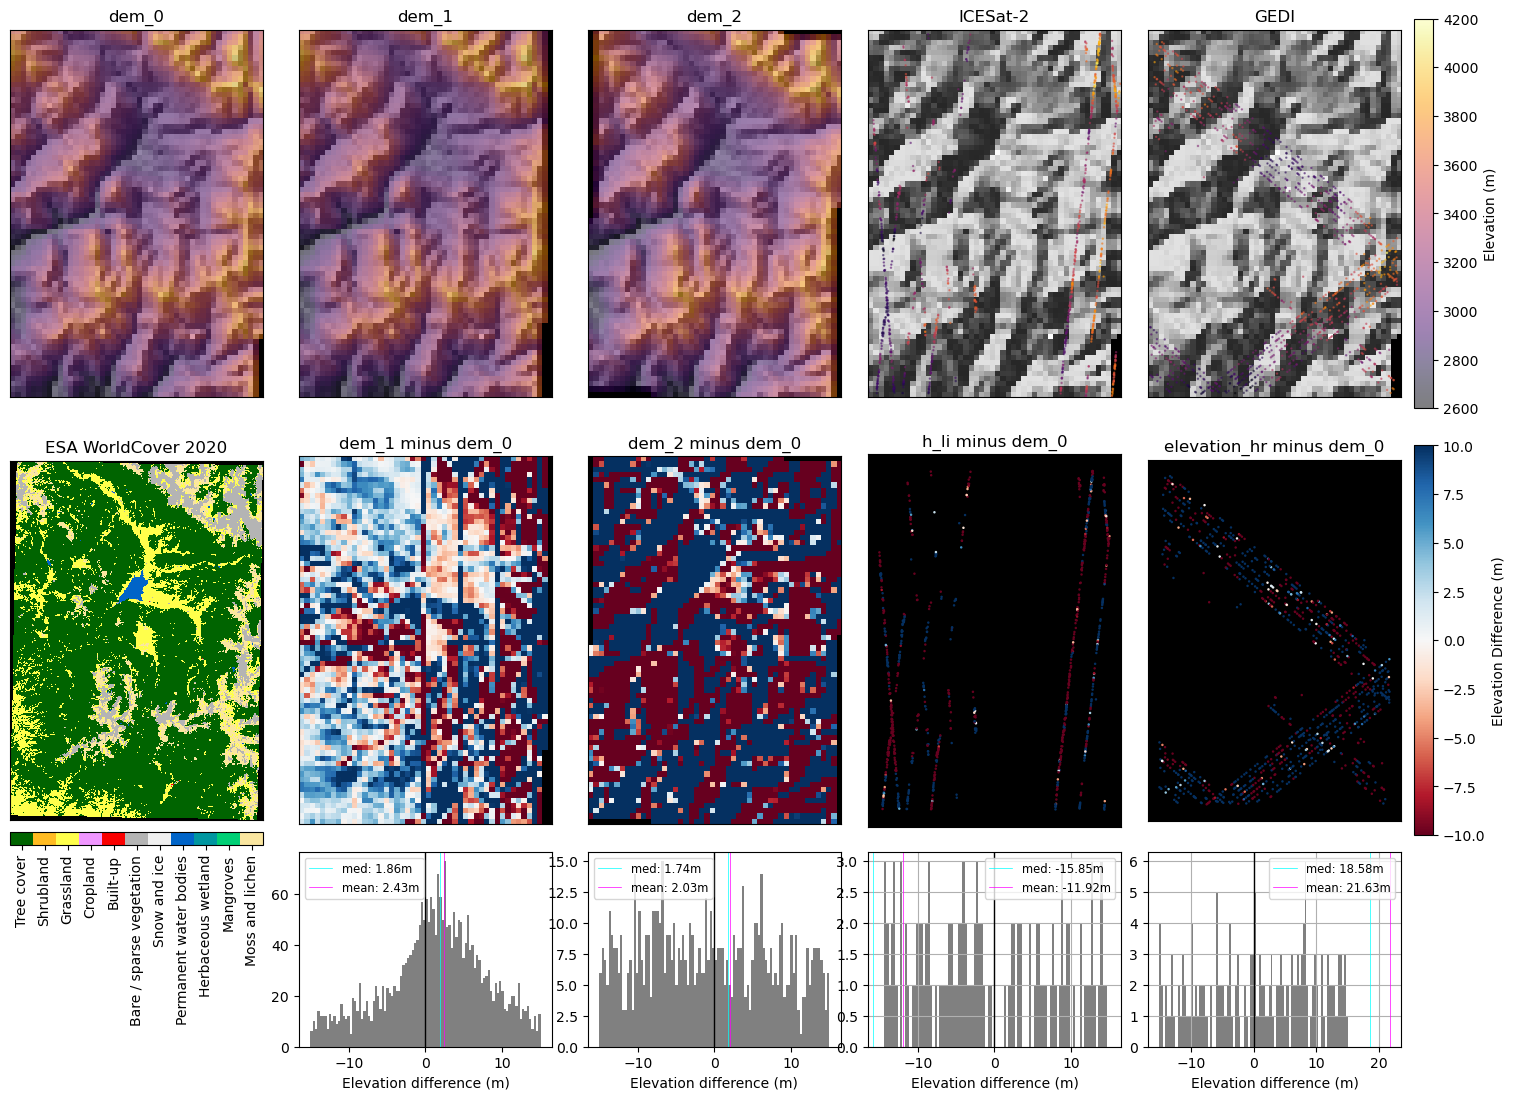

In [5]:
# Parameters
# ------------
# list of DEMs to compare, where the first DEM in the list is the 'source' DEM
dem_list = [dsm_lidar, dsm_stereo_r, da_cop30_r]
# dictionary of GeoDataFrames with altimetry points to compare
# where the key is the name/plot title of the dataset and the value is a tuple of the respective
# GeoDataFrame and the column name of the elevation values of interest
dicts_gds = {"ICESat-2": (subset_is2, "h_li"), "GEDI": (subset_gedi, "elevation_hr")}

fig = coincident.plot.compare_dems(
    dem_list,
    dicts_gds,
    elevation_cmap="inferno",  # elevation colormap
    elevation_clim=(2600, 4200),  # elevation colormap limits
    diff_cmap="RdBu",  # difference colormap
    diff_clim=(-10, 10),  # difference colormap limits
)
# NOTE: altimeter point size looks too small when the hillshades have such a large cell size and we only use 1000 points
# working on making this a parameter...

/home/jehayes/coincident/.pixi/envs/dev/lib/python3.12/site-packages/rasterio/features.py:336: ShapeSkipWarning: Invalid or empty shape geometry at index 0 will not be rasterized.
  warnings.warn(


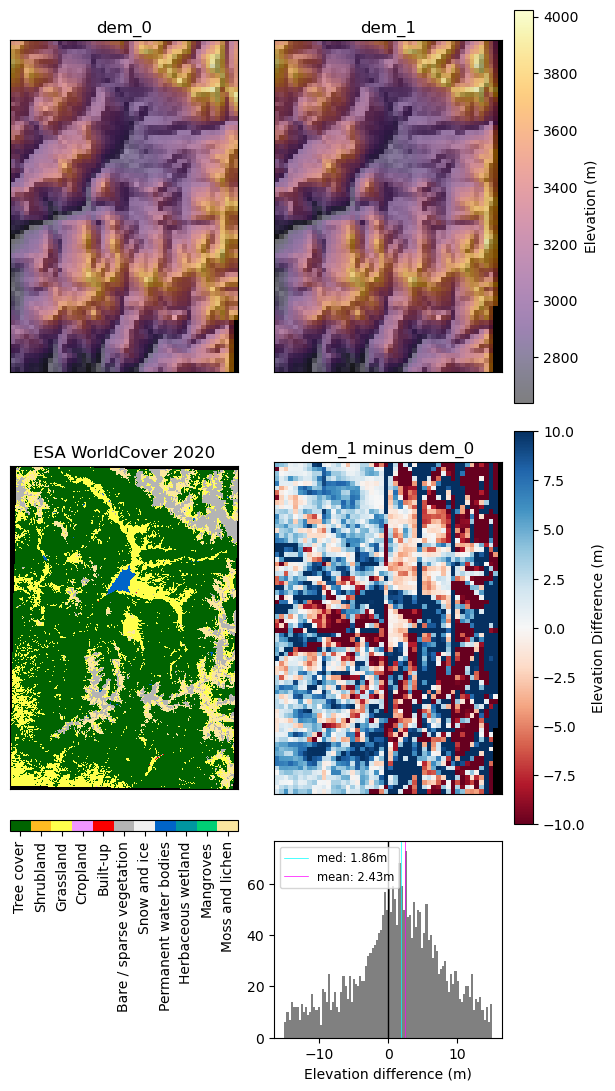

In [6]:
# we can also use this function with only 2 DEMs and no altimetry points if desired
fig2 = coincident.plot.compare_dems(
    dem_list[:2],
)

In [ ]:
# or just include one point GeoDataFrame with one other DEM
fig3 = coincident.plot.compare_dems(dem_list[:2], {"ICESat-2": (subset_is2, "h_li")})

### Dynamic Histograms and Boxplots for Elevation Differences based on Landcover class and Topographic Variables Coming Soon...